#Topic Modelling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
from pprint import pprint

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(sentence):
    # Lowercase
    sentence = sentence.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
    sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = re.sub(r'https\S+', '', sentence)
    # Remove double spacing
    sentence = re.sub('\s+', ' ', sentence)
    
    # Tokenize & remove stop-words
    word_list = nltk.word_tokenize(sentence)    
    stopwords_list = nltk.corpus.stopwords.words('english')
    stopwords_list.extend(['thank','today','join','astrazeneca','pfizer','biogen','johnson','amp','gsk','jnj','lt'])
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # Remove very small words, length < 3, they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 3]
        
    # Stem & Lemmatize
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = [porter_stemmer.stem(word) for word in word_list]
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    
    sentence = ' '.join(word_list)
    
    return sentence

In [ ]:
# Constants
file1 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'CDCgov'+'.csv'
file2 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'IHSgov'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GovCanHealth'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GCIndigenous'+'.csv'
df = pd.concat(
map(pd.read_csv, [file1, file2, file3, file4]), ignore_index=True)

# PHARMA_PATH = '../../data/twitter/pharma companies'
# GOVT_INSTITUTES_PATH = '../../data/twitter/govt institutes'
# NGO_PATH = '/content/drive/MyDrive/Project 2/data/ngo_who/'+'WHO'+'.csv'

EPOCHS = 205
TOPICS = 5
CHUNK_SIZE = 1000
WORKERS = 7
EVAL_PERIOD = 10
ALPHA = 0.01
BETA = 0.9

In [ ]:

print(df.shape)

(66812, 13)


In [ ]:
# Convert 'created_at' column to datetime
df['created_at'] = df['created_at'].str[:-6]
df['created_at'] = pd.to_datetime(df['created_at'])

# Sort by datetime ascending
df = df.sort_values(by='created_at')

# Pre-process the dataset
tqdm.tqdm.pandas()
df['tweet_tokenized'] = df['tweet'].progress_apply(lambda x:preprocess_text(str(x)))

100%|██████████| 66812/66812 [01:33<00:00, 710.81it/s]


Generate TF-IDF

In [ ]:
documents = df['tweet_tokenized'].str.split()
dictionary = gensim.corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

tfidf_model = gensim.models.TfidfModel(dictionary=dictionary)

corpus = [dictionary.doc2bow(d) for d in documents]
corpus_tfidf = list(tfidf_model[corpus])
performance_metrics = pd.DataFrame(columns=['feature-extraction','clustering-algo','run#', 'state', 'c_v', 'c_umass','topics','time'])

LDA

In [ ]:
for run, state in zip(range(2, 3, 1), range(4, 6, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=state, alpha=ALPHA, eta=BETA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lda.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 2


<ipython-input-10-0fc48290541a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


NMF

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_nmf = gensim.models.Nmf(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, eval_every=EVAL_PERIOD, minimum_probability=0, 
                                   random_state=state, kappa=1)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_nmf.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-12-5c68f8286f4d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


LSI

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lsi = gensim.models.LsiModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lsi.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-15-88e3d624a2bc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


HDP

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_hdp = gensim.models.hdpmodel.HdpModel(corpus=corpus_tfidf, id2word=dictionary, chunksize=CHUNK_SIZE, random_state=state, kappa=1, alpha=ALPHA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_hdp.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-17-b61ff710b833>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


In [ ]:
performance_metrics.to_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-modelling/public-lda-nmf-lsi-hdp.csv',index=False)

#Topic Propagation

In [ ]:
import glob
import numpy as np
import pandas as pd
import re
import ast

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-keywords/topic-keywords-public.csv')

In [ ]:
topic_df.shape

(5, 3)

In [ ]:
topic_df.columns

Index(['time-phase', 'topic', 'topic-keywords'], dtype='object')

In [ ]:
def isPhraseIn(phrase, text):
    '''
    Returns a boolean value testifying if the phrase exists in the tweet
    '''
    return re.search(r"\b{}\b".format(phrase), text, re.IGNORECASE) is not None

In [ ]:
user_topic_df = pd.DataFrame(columns=['username','topic','tweetCount'])
GOVT_INSTITUTES_PATH = '/content/drive/MyDrive/Project 2/data/public_health_agencies'
for file in glob.glob(GOVT_INSTITUTES_PATH + "/*.csv"):
    user_df = pd.read_csv(file)
    username = user_df['username'].unique()[0]
    
   
    print('='*100)
    print('2020-2022: ', username)
    for topic_index, topic_row in topic_df[topic_df['time-phase']=='X'].iterrows():
        topic = topic_row['topic']
        # print(topic)
        keywords = ast.literal_eval(topic_row['topic-keywords'])
        # print(keywords)
        topic_user_tweet_count = 0
        
        for index, row in user_df.iterrows():
            for phrase in keywords:
                # print(phrase)
                if(isinstance(row.tweet, float)):
                    row.tweet = str(row.tweet)
                if phrase in row.tweet:                    
                    topic_user_tweet_count += 1
        
        print(topic, topic_user_tweet_count)
        
        user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
    
# pre_covid_topic_df.to_csv('pre-covid-pharma-companies.csv', index=False)
user_topic_df.to_csv('during-covid-public.csv', index=False)

2020-2022:  CDCgov
General health 1850


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 2306


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 2067


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Communication 719


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Youth health 195
2020-2022:  IHSgov


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


General health 602


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 329


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 438


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Communication 148


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Youth health 103


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  GovCanHealth
General health 13353


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 18170


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 27937


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Communication 17989


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Youth health 4112
2020-2022:  GCIndigenous


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


General health 376


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 381


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 956


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Communication 338


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Youth health 156


<ipython-input-33-96e704ba20c4>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


# Heatmaps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import seaborn as sns
import textwrap

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-propagation/topic-propagation-public.csv')
df.set_index('Org', inplace=True)
df

General Health  COVID-19  Community Health  Communication  \
Org                                                                       
CDCgov                  1850      2306              2067            719   
IHSgov                   602       329               438            148   
GovCanHealth           13353     18170             27937          17989   
GCIndigenous             376       381               956            338   

              Youth Health  
Org                         
CDCgov                 195  
IHSgov                 103  
GovCanHealth          4112  
GCIndigenous           156

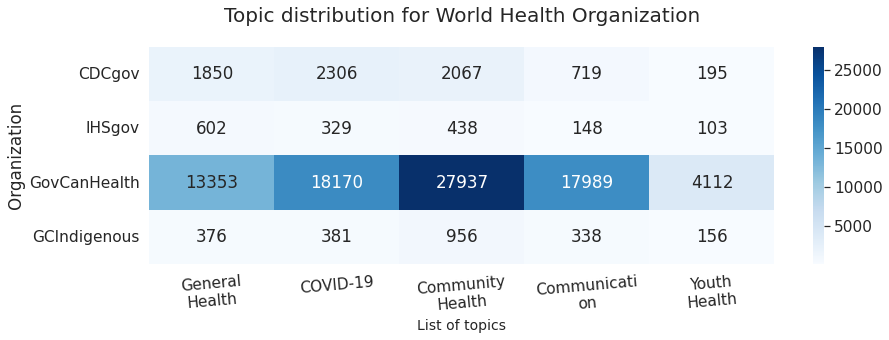

In [ ]:
plt.figure(figsize = (14,4))
plt.rcParams['axes.titlepad'] = 25
sns.set(font_scale=1.4)

# ax = sns.heatmap(df, annot=True, cmap='Blues',fmt='g')
ax = sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title('Topic distribution for World Health Organization', fontdict={'fontsize':20})
plt.xlabel('List of topics')
plt.ylabel('Organization')
ax.xaxis.label.set_size(14)
ax.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in ax.get_xticklabels())
plt.xticks(rotation=5)
plt.savefig('pharmaceutical-companies.pdf', transparent=True, bbox_inches='tight')
plt.savefig('pharmaceutical-companies.png', transparent=True, bbox_inches='tight')
plt.show()

# Hashtags & Mentions

In [ ]:
!pip install advertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
import advertools as adv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remove_tags(tweet):
    return re.sub('#dyk|#unsubscribe','',tweet)

In [ ]:
def hashtags(data,column):
    hashtag_summary = adv.extract_hashtags(data[column].astype('str').values.tolist())    
    plt.figure(figsize=(14, 6))
    plt.barh([x[0] for x in hashtag_summary['top_hashtags'][:10]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][:10]][::-1])
    plt.title('Top Hashtags for {}'.format(data.name))
    
    plt.show()
    print(hashtag_summary['top_hashtags'][:10])
    return print("hashtag_overview:",hashtag_summary['overview'])
def mentions(data,column):
  mention_summary = adv.extract_mentions(data[column].astype('str').values.tolist())
  plt.figure(figsize=(15,6))
  plt.barh([x[0] for x in mention_summary['top_mentions'][:10]][::-1],
        [x[1] for x in mention_summary['top_mentions'][:10]][::-1])
  plt.title('Top Mentions for {}'.format(data.name))
  plt.show()
  print(mention_summary['top_mentions'][:10])
  return print("overview:",mention_summary['overview'])

In [ ]:
PATH = '/content/drive/MyDrive/Project 2/data/public_health_agencies'

In [ ]:
pharma_df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob(PATH + "/*.csv")],ignore_index=True)
pharma_df['name'] = 'Pharma Companies'


In [ ]:
# Convert 'created_at' column to datetime
pharma_df['created_at'] = pharma_df['created_at'].str[:-6]
pharma_df['created_at'] = pd.to_datetime(pharma_df['created_at'])

# Sort by datetime ascending
pharma_df = pharma_df.sort_values(by='created_at')

pharma_df['tweet'] = pharma_df['tweet'].str.replace('#jnj|#dyk|#stop|#unsubscribe','',regex=True,case=False)

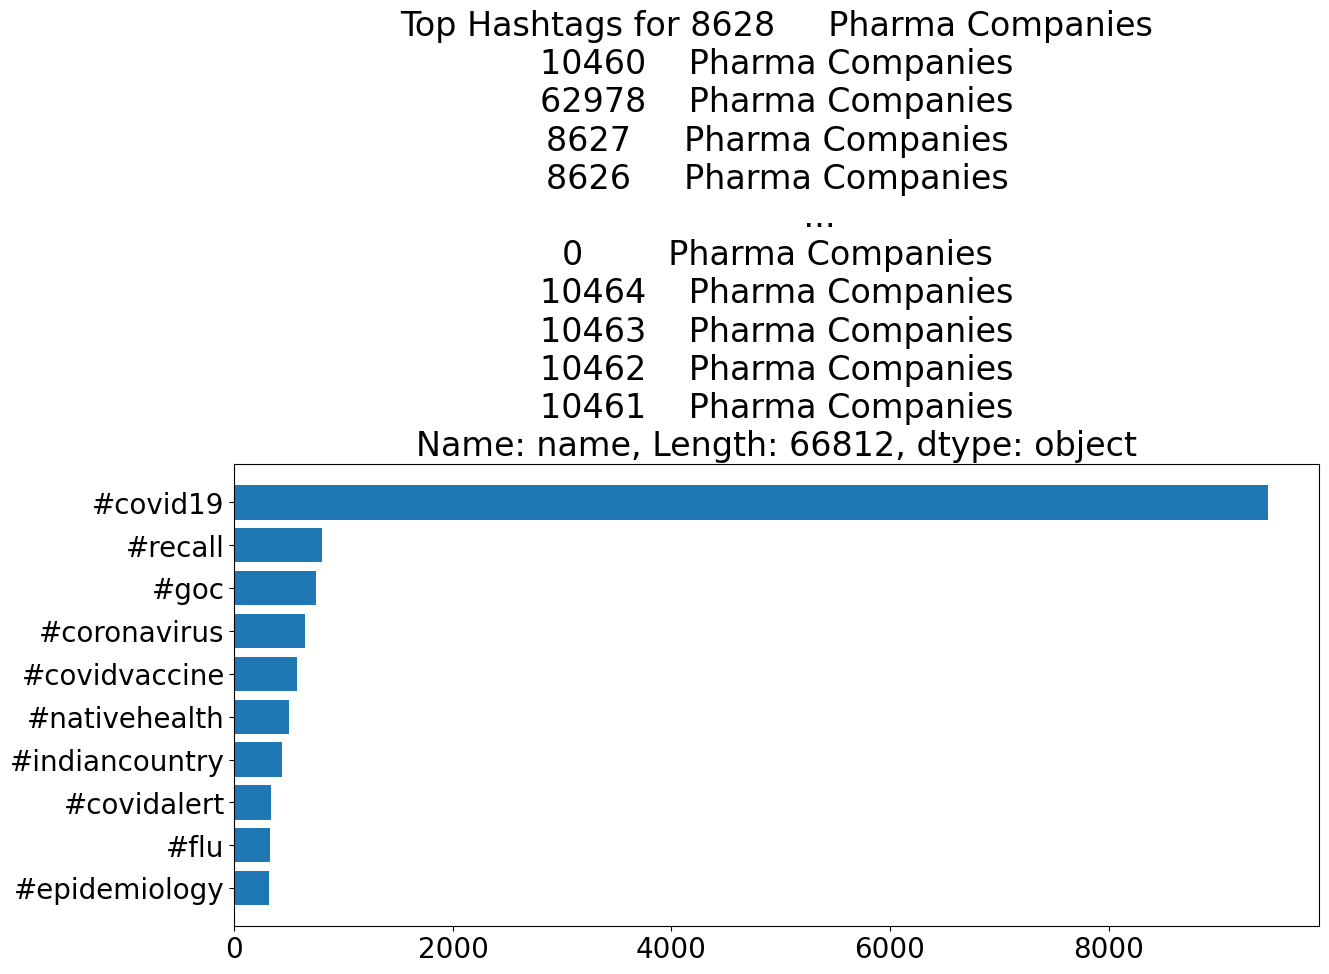

[('#covid19', 9458), ('#recall', 803), ('#goc', 745), ('#coronavirus', 643), ('#covidvaccine', 568), ('#nativehealth', 497), ('#indiancountry', 436), ('#covidalert', 338), ('#flu', 322), ('#epidemiology', 315)]
hashtag_overview: {'num_posts': 66812, 'num_hashtags': 31689, 'hashtags_per_post': 0.47430102376818534, 'unique_hashtags': 3495}


In [ ]:
hashtags(pharma_df, 'tweet')

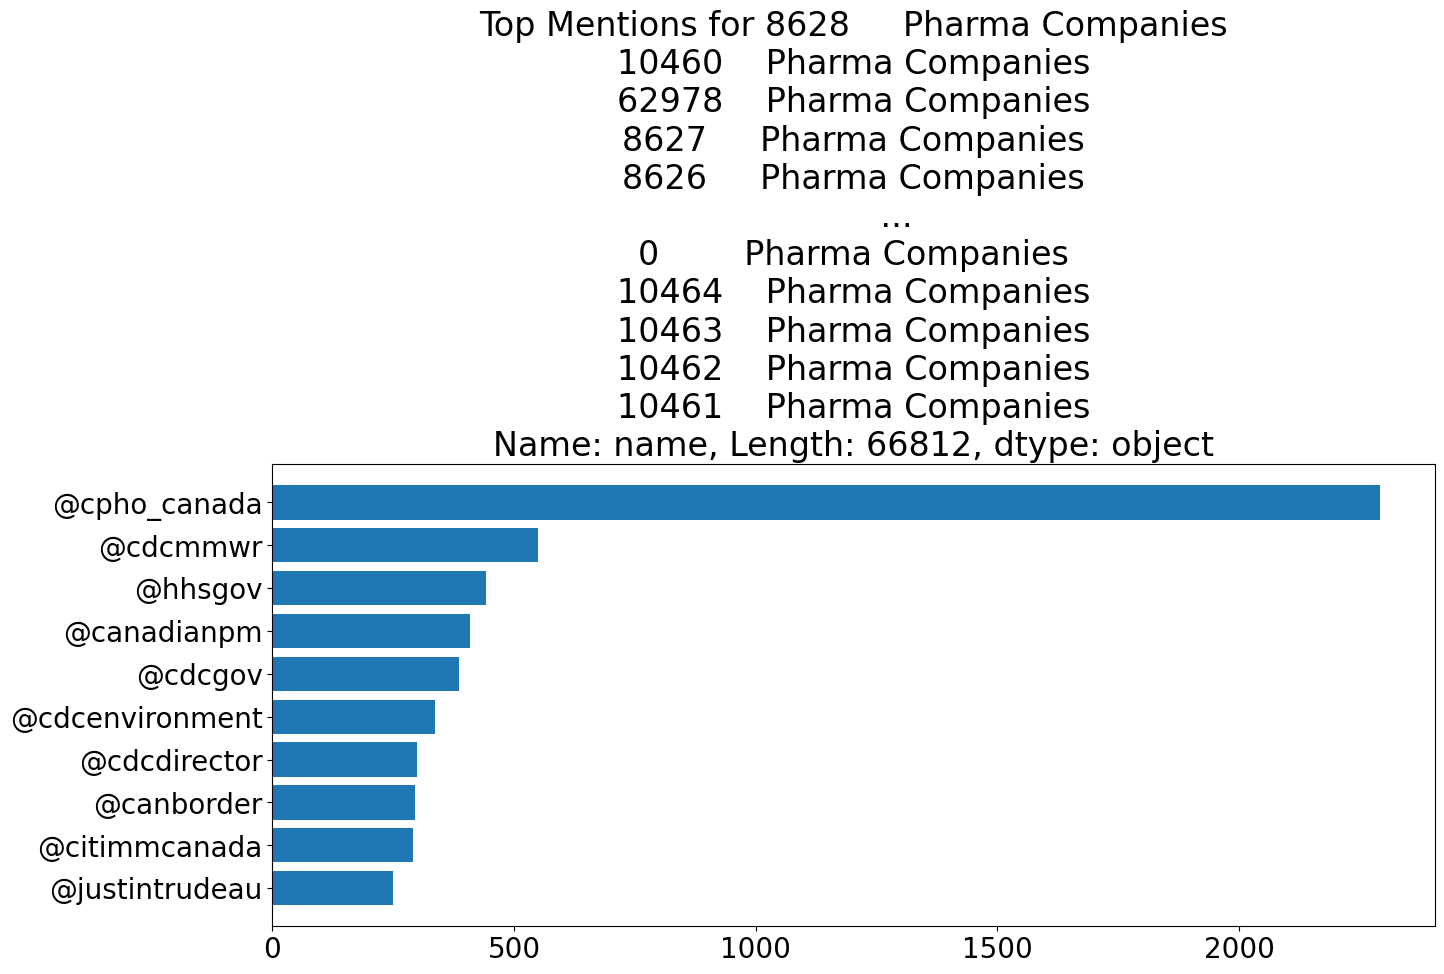

[('@cpho_canada', 2291), ('@cdcmmwr', 549), ('@hhsgov', 442), ('@canadianpm', 409), ('@cdcgov', 386), ('@cdcenvironment', 337), ('@cdcdirector', 299), ('@canborder', 295), ('@citimmcanada', 290), ('@justintrudeau', 249)]
overview: {'num_posts': 66812, 'num_mentions': 58193, 'mentions_per_post': 0.870996228222475, 'unique_mentions': 13790}


In [ ]:
mentions(pharma_df,'tweet')

#Pre-processing

In [2]:
 !pip install -qq -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy
from numpy.random import randint
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.flow import shortest_augmenting_path
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
PORTER_STEMMER = PorterStemmer()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def clean_tweets(x, STOPWORDS):
    # Lowercase
    sentence = x.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub('http[s]?://\S+', '', sentence)
    sentence = re.sub(r'([^a-zA-Z ]+?)', '', sentence)
    #print(sentence)
    #sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = sentence.replace("world health organization", "who")
    #print(sentence)
    # Remove double spacing
    #sentence = re.sub('\s+', ' ', sentence)
    tokenized_tweet = [word for word in word_tokenize(sentence) if word not in STOPWORDS]
    tokenized_tweet = [PORTER_STEMMER.stem(word) for word in tokenized_tweet]
    return tokenized_tweet

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-5-e9114ee358bb>:6: DeprecationWarning: invalid escape sequence \S
  sentence = re.sub('http[s]?://\S+', '', sentence)


In [6]:
pharma_username = ['pfizer']
#'JNJNews', 'AstraZeneca', 'GSK', 'Novartis'
public_username = ['CDCgov', 'IHSgov', 'GovCanHealth', 'GCIndigenous']
ngo_username = ['WHO']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# file1 = '/content/drive/MyDrive/Project 2/data/ngo_who/'+'WHO'+'.csv'
file2 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'CDCgov'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'IHSgov'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GovCanHealth'+'.csv'
file5 = '/content/drive/MyDrive/Project 2/data/public_health_agencies/'+'GCIndigenous'+'.csv'
Sample_Tweets = pd.concat(
map(pd.read_csv, [file2, file3, file4, file5]), ignore_index=True)
print(Sample_Tweets)
# dataFrame.to_csv('/content/drive/MyDrive/Project 2/gephi/public_health_agencies/public_merged.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                        id                 created_at      conversation_id  \
0      1608942276117512193  2022-12-30 21:45:05+00:00  1608942276117512193   
1      1608925918264803328  2022-12-30 20:40:05+00:00  1608925918264803328   
2      1608915854967689224  2022-12-30 20:00:06+00:00  1608915854967689224   
3      1608908806196531200  2022-12-30 19:32:06+00:00  1608908806196531200   
4      1608898236483309568  2022-12-30 18:50:06+00:00  1608898236483309568   
...                    ...                        ...                  ...   
66807  1215755262369374216  2020-01-10 22:00:16+00:00  1215755262369374216   
66808  1215364834415521792  2020-01-09 20:08:51+00:00  1215364834415521792   
66809  1214286619458584577  2020-01-06 20:44:25+00:00  1214286619458584577   
66810  1213811169435291648  2020-01-05 13:15:08+00:00  1213811169435291648   
66811  1213086419318644736  2020-01-03 13:15:15+00:00  1213086419318644736   

                                                   tweet  retwe

In [ ]:
Sample_Tweets = Sample_Tweets.sample(n=10)

In [ ]:
Sample_Tweets.iloc[0]

id                                                   1542616744874967040
created_at                                     2022-06-30 21:11:07+00:00
conversation_id                                      1542616744874967040
tweet                  Children receive smaller doses of the #COVID19...
retweet_count                                                          1
like_count                                                             7
reply_count                                                           15
quote_count                                                            0
expanded_url           https://twitter.com/CDCgov/status/154261674487...
language                                                              en
possibly_sensitive                                                 False
in_reply_to_user_id                                                  NaN
username                                                          CDCgov
Name: 0, dtype: object

In [9]:
stopwords_df = set(nltk.corpus.stopwords.words("english"));
# stopwords_df.add("rt")
# stopwords_df.add("amp")
# stopwords_df.add("get")
# stopwords_df.add("It")
print(stopwords_df)

{'she', 'hasn', 'didn', 'before', 'y', 'very', 'through', 'mightn', 'nor', 'having', 'his', 'do', 'and', "she's", 'both', 'until', 'should', 'where', 'o', "hasn't", 'more', 'off', 'be', 'himself', 'any', "hadn't", 'only', 'once', 'themselves', 'against', 'down', 'herself', 'being', 'is', 'there', 'as', 'doesn', 'out', 'how', "won't", 'we', 'over', 'about', 'it', 'them', 'your', 'was', 'yours', 'theirs', 'her', 'just', 'because', 's', 'him', 'ma', "don't", 'i', 'am', 'yourselves', 'their', 'of', 'doing', 'during', "aren't", 'too', "it's", 'after', 'has', 'what', 'on', "that'll", 'the', 'can', 'm', 've', 'yourself', "you're", 'no', 'me', "weren't", 'isn', 'a', 'wouldn', "you'd", 'under', 'my', 'mustn', 'in', 'did', 'than', 'ain', 'itself', 'between', 'its', 'were', 'needn', "wouldn't", 'when', 'this', "mustn't", 'these', 'with', "doesn't", 'further', 'he', "mightn't", "didn't", 'most', 'so', "shouldn't", 'had', 'all', 'some', 'same', 'are', 'then', 'couldn', "couldn't", 'shan', 'for', 'a

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Word Cloud

In [ ]:
df = None
Tweet_Texts=Sample_Tweets['tweet'].values

# Converting the text column as a single string for wordcloud
Tweets_String=str(Tweet_Texts)

# Tweet Text cleaning
import re

# Converting the whole text to lowercase
Tweet_Texts_Cleaned = Tweets_String.lower()

# Removing the twitter usernames from tweet string
Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

# Removing the URLS from the tweet string
Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


# Deleting everything which is not characters
Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

# Deleting any word which is less than 3-characters mostly those are stopwords
Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

# Stripping extra spaces in the text
Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

Tweet_Texts_Cleaned
# for username in pharma_username:

  # Sample_Tweets = pd.read_csv('/content/drive/MyDrive/Project 2/data/pharma_companies/'+username+'.csv')

  #only 10 rows
  # Sample_Tweets = Sample_Tweets[:10]
  
  #clean tweets
  # Extracting only the Tweet text from the data frame
  # Tweet_Texts=Sample_Tweets['tweet'].values

  # # Converting the text column as a single string for wordcloud
  # Tweets_String=str(Tweet_Texts)

  # # Tweet Text cleaning
  # import re

  # # Converting the whole text to lowercase
  # Tweet_Texts_Cleaned = Tweets_String.lower()

  # # Removing the twitter usernames from tweet string
  # Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

  # # Removing the URLS from the tweet string
  # Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


  # # Deleting everything which is not characters
  # Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

  # # Deleting any word which is less than 3-characters mostly those are stopwords
  # Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

  # # Stripping extra spaces in the text
  # Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

  # Tweet_Texts_Cleaned

' science has given powerful tools prevent detect and treat covid use them well the covid pandemic not over but can with vaccinequity the covid vaccine delivery partnership doing this helping countries access funding facilitate delivery engaging with political leaders providing technical assistance such advising targeting vaccination campaigns risk populations happynewyear nto achieve healthforall the will need million more nurses and midwives urging countries healthy resolution limit use alcohol happynewyear healthy resolution say notobacco happynewyear '

In [ ]:
print(Tweet_Texts_Cleaned)

 children receive smaller doses the covid vaccine based their age like the adult vaccine the children vaccine helps keep them from getting seriously sick children and teens may get covid vaccines and other vaccines the same time you have questions talk your healthcare provider june million people have received least one dose covid vaccine those million are fully vaccinated more than million people have received covid booster dose nfind covid vaccine booster near you jordansprinciple can help firstnations children who need educational products services supports such teaching educational assistants find out more learn more about jordansprinciple announce the coming into force bill act respecting first nations inuit and tis children youth and famil 


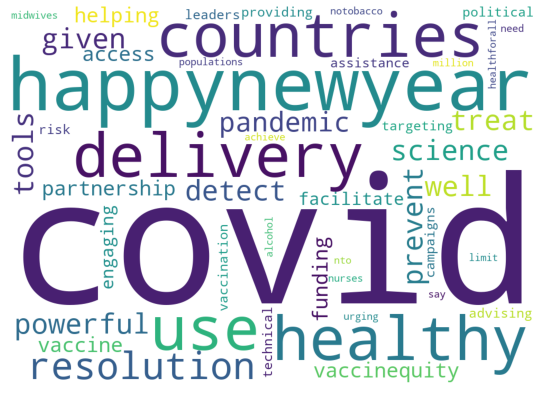

In [ ]:
# Plotting the wordcloud 
# you can specify fonts, stopwords, background color and other options
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Creating the custom stopwords
customStopwords=list(stopwords_df)

wordcloudimage = WordCloud(
                          max_words=100,
                          max_font_size=500,
                          font_step=2,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts_Cleaned)

plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

#ARM (Itemsets)

In [11]:
len(pd.read_csv(file1))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


25989

In [10]:
from google.colab import output
output.enable_custom_widget_manager()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
df = Sample_Tweets
  
#clean tweets
tqdm.pandas()
df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
tokenized_tweets = df["tokenized_tweet"].values.tolist()
te = TransactionEncoder()
te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
df = pd.DataFrame(te_ary, columns=te.columns_)


  

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/66812 [00:00<?, ?it/s]

In [13]:
#Itemsets


min_sup=0.5
frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
print("len of frequent itemsets: ", len(frequent_itemsets.index))

while(len(frequent_itemsets.index)<100):
  min_sup = min_sup/2
  frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  print("len of frequent itemsets: ", len(frequent_itemsets.index))

itemsets_df = frequent_itemsets[:100] 
print(itemsets_df)
itemsets_df.to_csv("itemsets.csv");


# for username in pharma_username:

  # df = pd.read_csv('/content/drive/MyDrive/Project 2/data/pharma_companies/'+username+'.csv')
  
  #only 10 rows
  # df = df[:10]
  # df = Sample_Tweets

  # #clean tweets
  # tqdm.pandas()
  # df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
  # tokenized_tweets = df["tokenized_tweet"].values.tolist()
  # te = TransactionEncoder()
  # te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
  # df = pd.DataFrame(te_ary, columns=te.columns_)

  # #Itemsets
  
  
  # min_sup=0.5
  # frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  # print("len of frequent itemsets: ", len(frequent_itemsets.index))

  # while(len(frequent_itemsets.index)<100):
  #   min_sup = min_sup/2
  #   frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  #   print("len of frequent itemsets: ", len(frequent_itemsets.index))

  # itemsets_df = frequent_itemsets[:100] 
  # print(itemsets_df)
  # itemsets_df.to_csv("itemsets.csv");


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


len of frequent itemsets:  0
len of frequent itemsets:  8
len of frequent itemsets:  54
len of frequent itemsets:  1018
     support         itemsets
0   0.136053         (canada)
1   0.062803           (caus)
2   0.412755          (covid)
3   0.075900         (effect)
4   0.087739          (everi)
..       ...              ...
95  0.172215  (vaccin, learn)
96  0.064015  (lower, optout)
97  0.064030     (lower, put)
98  0.064015   (lower, repli)
99  0.065303    (lower, risk)

[100 rows x 2 columns]


covid      15
help       13
optout     11
learn      10
everyon     9
repli       9
effect      8
everi       6
stop        6
friday      6
Name: Items, dtype: int64


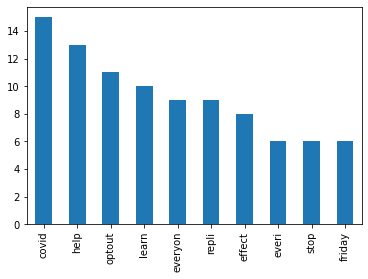

In [ ]:

allItems = []
for i in itemsets_df['itemsets']:
    for j in i:
        allItems.append(j)
        
bar_df = pd.DataFrame(allItems, columns=['Items'])
print(bar_df['Items'].value_counts().head(10))
bar_df['Items'].value_counts().head(10).plot.bar()

In [ ]:
df

a     aa  aackeri  aacvpr  aadncinfopubsaandccanadaca  aadubyk  \
0      False  False    False   False                       False    False   
1      False  False    False   False                       False    False   
2      False  False    False   False                       False    False   
3      False  False    False   False                       False    False   
4      False  False    False   False                       False    False   
...      ...    ...      ...     ...                         ...      ...   
65558  False  False    False   False                       False    False   
65559  False  False    False   False                       False    False   
65560  False  False    False   False                       False    False   
65561  False  False    False   False                       False    False   
65562  False  False    False   False                       False    False   

       aafccanada  aagotii  aaimcloud   aaip  ...  zuzubear  zxatun  zxthix  \
0           False    False      False  False  ...     False   False   False   
1           False    False      False  False  ...     False   False   False   
2           False    False      False  False  ...     False   False   False   
3           False    False      False  False  ...     False   False   False   
4           False    False      False  False  ...     False   False   False   
...           ...      ...        ...    ...  ...       ...     ...     ...   
65558       False    False      False  False  ...     False   False   False   
65559       False    False      False  False  ...     False   False   False   
65560       False    False      False  False  ...     False   False   False   
65561       False    False      False  False  ...     False   False   False   
65562       False    False      False  False  ...     False   False   False   

       zygmunt  zymeerjemison  zytec  zzellera  zzhennan  zzulfiali    zzz  
0        False          False  False     False     False      False  False  
1        False          False  False     False     False      False  False  
2        False          False  False     False     False      False  False  
3        False          False  False     False     False      False  False  
4        False          False  False     False     False      False  False  
...        ...            ...    ...       ...       ...        ...    ...  
65558    False          False  False     False     False      False  False  
65559    False          False  False     False     False      False  False  
65560    False          False  False     False     False      False  False  
65561    False          False  False     False     False      False  False  
65562    False          False  False     False     False      False  False  

[65563 rows x 29903 columns]

    Confidence  Number of rules
0          0.0              142
1          0.1              142
2          0.2              142
3          0.3              140
4          0.4              129
5          0.5              101
6          0.6               80
7          0.7               69
8          0.8               55
9          0.9               46
10         1.0                7


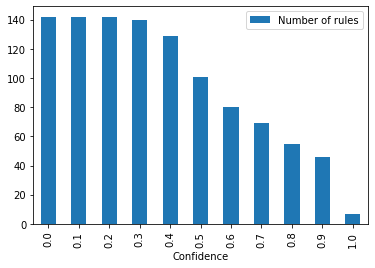

In [ ]:
frequent_itemsets2 = apriori(df, min_support=0.125, use_colnames=True)
frequent_itemsets2

confidence = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
number_of_rules = []

for i in confidence:
    a = association_rules(frequent_itemsets2, metric="confidence", min_threshold=i)
    number_of_rules.append(len(a))

data = {'Confidence': confidence, 'Number of rules': number_of_rules}
df2 = pd.DataFrame(data=data)
print(df2)
plot = df2.plot.bar(x='Confidence', y='Number of rules')

In [ ]:
association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)


antecedents            consequents  antecedent support  \
0            (learn)                (covid)            0.226805   
1               (lt)                (covid)            0.169852   
2            (repli)                (covid)            0.341443   
3            (covid)               (vaccin)            0.423059   
4           (vaccin)                (covid)            0.304135   
..               ...                    ...                 ...   
96    (covid, repli)         (stop, vaccin)            0.193249   
97   (covid, vaccin)          (stop, repli)            0.275735   
98   (repli, vaccin)          (stop, covid)            0.178470   
99           (repli)  (stop, covid, vaccin)            0.341443   
100         (vaccin)   (stop, covid, repli)            0.304135   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.423059  0.194988    0.859718  2.032147  0.099036    4.112712  
1              0.423059  0.169654    0.998833  2.360979  0.097796  494.216762  
2              0.423059  0.193249    0.565979  1.337825  0.048799    1.329293  
3              0.304135  0.275735    0.651765  2.143012  0.147068    1.998262  
4              0.423059  0.275735    0.906620  2.143012  0.147068    6.178415  
..                  ...       ...         ...       ...       ...         ...  
96             0.175770  0.174519    0.903078  5.137844  0.140552    8.504068  
97             0.224929  0.174519    0.632924  2.813887  0.112498    2.111474  
98             0.178805  0.174519    0.977865  5.468888  0.142608   37.099619  
99             0.175709  0.174519    0.511123  2.908920  0.114525    1.686091  
100            0.174519  0.174519    0.573821  3.288014  0.121442    1.936937  

[101 rows x 9 columns]

#ARM (Rules)

In [ ]:
matrix_df = pd.DataFrame(columns=['Threshold Support', 'Threshold Confidence', 'Count of rules'])
for min_support_initialize in np.arange(0.01, 0.1, 0.00625): #0.125, 0.5, 0.0625
  for min_threshold_initialize in np.arange(0.5, 1, 0.1):
    frequent_itemsets_temp = apriori(df, min_support=min_support_initialize, use_colnames=True)
    if(frequent_itemsets_temp.empty):
      continue
    rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=min_threshold_initialize)
  # rules = rules.sort_values(by='confidence', ascending =False)
  # print(rules)
    matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
  
print(matrix_df)

    Threshold Support  Threshold Confidence  Count of rules
0              0.0100                   0.5          1783.0
1              0.0100                   0.6          1252.0
2              0.0100                   0.7          1099.0
3              0.0100                   0.8          1022.0
4              0.0100                   0.9           930.0
..                ...                   ...             ...
70             0.0975                   0.5             1.0
71             0.0975                   0.6             0.0
72             0.0975                   0.7             0.0
73             0.0975                   0.8             0.0
74             0.0975                   0.9             0.0

[75 rows x 3 columns]


In [ ]:
matrix_df.to_csv('Support vs Confidence for WHO.csv')

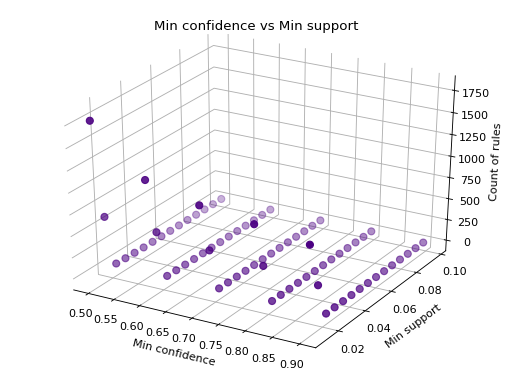

In [ ]:
from IPython.core.pylabtools import figsize
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(8, 6), dpi=80)

# syntax for 3-D projection
ax = plt.axes(projection ='3d', )

# defining all 3 axes
z = matrix_df['Count of rules']
x = matrix_df['Threshold Confidence']
y = matrix_df['Threshold Support']

# plotting

ax.scatter(x, y, z, color='indigo', s=40)
ax.set_title('Min confidence vs Min support')
ax.set_xlabel('Min confidence')
ax.set_ylabel('Min support')

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.grid(False)

ax.set_zlabel('Count of rules')
plt.show()


In [19]:
# 0              0.1250                   0.5           101.0

# 4              0.01                   0.8         0
frequent_itemsets_temp = apriori(df, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=0.9)
rules[rules['lift']>=1]
print(rules)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        antecedents                            consequents  \
0              (lt)                                (covid)   
1              (lt)                                (learn)   
2              (lt)                               (vaccin)   
3         (resourc)                               (optout)   
4             (tip)                               (optout)   
..              ...                                    ...   
975    (optout, lt)    (vaccin, stop, covid, learn, repli)   
976   (stop, learn)     (vaccin, optout, covid, repli, lt)   
977      (stop, lt)  (vaccin, optout, covid, repli, learn)   
978  (learn, repli)      (vaccin, optout, stop, covid, lt)   
979     (repli, lt)   (vaccin, optout, stop, covid, learn)   

     antecedent support  consequent support   support  confidence      lift  \
0              0.161468            0.412755  0.161243    0.998610  2.419375   
1              0.161468            0.227265  0.160929    0.996663  4.385475   
2              0.1

In [ ]:
type(rules)

pandas.core.frame.DataFrame

In [21]:
df1 = (rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))
df1.to_csv('Public-health-agencies rules.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Bokeh plot

In [ ]:
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bokeh.io import output_notebook, show, save

In [ ]:
got_df = pd.read_csv('/content/WHO rules.csv')

In [ ]:
G = networkx.from_pandas_edgelist(got_df, 'antecedents', 'consequents')

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [ ]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [ ]:
title="Bokeh Plot for WHO"

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Character", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

#Add Labels
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)


show(plot)
#save(plot, filename=f"{title}.html")

In [ ]:
save(plot, filename=f"{title}.html")

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/content/Bokeh Plot for WHO.html'

#Followers (Maybe not)

In [ ]:
# !pip install -U -qq tweepy

In [ ]:
import tweepy

In [ ]:
# Initialize bearer token and client
bearer_token = "AAAAAAAAAAAAAAAAAAAAAD2hVAEAAAAAjBhkrfvf%2BEftzMPhDJt1oXHLCh4%3D0J5mIvBgW81rnqoNcUXOFMOCqv83ANsZZoELvCvxAYiYnUm4Ql"
client = tweepy.Client(bearer_token=bearer_token)

AttributeError: ignored

In [ ]:
def getUserInfo(client,username):
    user = client.get_user(username=username,user_fields='public_metrics')
    return user


d =getUserInfo(client,'pfizer')

d.data.public_metrics['followers_count']

In [ ]:
client.get_users_followers(id=56488059, max_results=100)

In [ ]:
def getTargetFollowers(n=100, m=150):
  screen_name = 'JoeBiden'
  target_followers = list()
  n = m
  f = tweepy.Cursor(api.get_followers(), screen_name).items(n)
  for fol in f:
    if not fol.protected:
      target_followers.append(fol.screen_name)
    if len(target_followers) == n:
      break
  print(len(target_followers))
  dff = pd.DataFrame(columns=target_followers)
  print(dff.shape)
  return(dff)

#Metrics
Recommender systems can also profit from the messages shared on social media 

The higher the popularity of a tweet, the more likely it is to contain highly supported association rule.




In [ ]:
Sample_Tweets['Tweet_rank'] = Sample_Tweets['like_count']+Sample_Tweets['quote_count']+Sample_Tweets['reply_count']+Sample_Tweets['retweet_count']

In [ ]:
Sample_Tweets = Sample_Tweets.sort_values(by=['Tweet_rank'], ascending=False)


In [ ]:
Sample_Tweets["tokenized_tweet"] = Sample_Tweets["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))


  0%|          | 0/24581 [00:00<?, ?it/s]

In [ ]:
Sample_Tweets

id                 created_at      conversation_id  \
24303  1217043229427761152  2020-01-14 11:18:12+00:00  1217043229427761152   
21955  1237777021742338049  2020-03-11 16:26:53+00:00  1237774421307228160   
21233  1243972193169616898  2020-03-28 18:44:17+00:00  1243972193169616898   
21970  1237721991471382528  2020-03-11 12:48:13+00:00  1237721991471382528   
14887  1313841832598687749  2020-10-07 14:01:17+00:00  1313841832598687749   
...                    ...                        ...                  ...   
1086   1522099819740909570  2022-05-05 06:24:10+00:00  1522099819740909570   
11649  1356994405111128072  2021-02-03 15:54:12+00:00  1356994405111128072   
19048  1262368554042654720  2020-05-18 13:04:51+00:00  1262368554042654720   
19046  1262369680397918208  2020-05-18 13:09:20+00:00  1262369680397918208   
18943  1262742422582226948  2020-05-19 13:50:28+00:00  1262742422582226948   

                                                   tweet  retweet_count  \
24303  Preliminary investigations conducted by the Ch...          23372   
21955  🚨 BREAKING 🚨\n\n"We have therefore made the as...          51313   
21233  FACT: #COVID19 is NOT airborne. \n\nThe #coron...          39560   
21970  These are 7 simple steps to protect yourself a...          31615   
14887  We are thrilled to have @SuperM joining our Bi...          18175   
...                                                  ...            ...   
1086                             https://t.co/BmNCAD0jmf              0   
11649                            https://t.co/wSojwxGRa5              0   
19048                            https://t.co/FUUYdc2Iv0              0   
19046                            https://t.co/qKkZVnASif              0   
18943                            https://t.co/C7q61yGb8r              0   

       like_count  reply_count  quote_count  \
24303       29369        15873        51657   
21955       52822         2011        13211   
21233       44307         2809         4266   
21970       37607          604         1804   
14887       45970          913         2899   
...           ...          ...          ...   
1086            0            0            0   
11649           0            0            0   
19048           0            0            0   
19046           0            0            0   
18943           0            0            0   

                                            expanded_url language  \
24303  https://twitter.com/WHO/status/121704322942776...       en   
21955  https://twitter.com/WHO/status/123777702174233...       en   
21233  https://twitter.com/WHO/status/124397219316961...       en   
21970                              http://bit.ly/337yabc       en   
14887          https://bit.ly/WHOBigEventforMentalHealth       en   
...                                                  ...      ...   
1086   https://twitter.com/WHO/status/152209981974090...      zxx   
11649  https://twitter.com/WHO/status/135699440511112...      zxx   
19048  https://twitter.com/WHO/status/126236855404265...      zxx   
19046  https://twitter.com/WHO/status/126236968039791...      zxx   
18943  https://twitter.com/WHO/status/126274242258222...      zxx   

       possibly_sensitive  in_reply_to_user_id username  \
24303               False                  NaN      WHO   
21955               False           14499829.0      WHO   
21233               False                  NaN      WHO   
21970               False                  NaN      WHO   
14887               False                  NaN      WHO   
...                   ...                  ...      ...   
1086                False                  NaN      WHO   
11649               False                  NaN      WHO   
19048               False                  NaN      WHO   
19046               False                  NaN      WHO   
18943               False                  NaN      WHO   

                                         tokenized_tweet  Tweet_rank  
24303  [prel

In [ ]:
Sample_Tweets["tokenized_tweet"]

24303    [preliminari, investig, conduct, chines, autho...
21955    [break, therefor, made, assess, covid, charact...
21233    [fact, covid, airborn, coronaviru, mainli, tra...
21970     [simpl, step, protect, other, covid, coronaviru]
14887    [thrill, superm, join, big, event, mental, hea...
                               ...                        
1086                                                    []
11649                                                   []
19048                                                   []
19046                                                   []
18943                                                   []
Name: tokenized_tweet, Length: 24581, dtype: object

In [ ]:
type(Sample_Tweets['tokenized_tweet'])

pandas.core.series.Series

In [ ]:
sorted_df = Sample_Tweets['tokenized_tweet']

In [ ]:
sorted_df.to_csv('sorted.csv')

In [ ]:
Sample_Tweets.iloc[0]['tweet']

'Preliminary investigations conducted by the Chinese authorities have found no clear evidence of human-to-human transmission of the novel #coronavirus (2019-nCoV) identified in #Wuhan, #China🇨🇳. https://t.co/Fnl5P877VG'

In [ ]:
rules['rank'] = rules['antecedent support']+rules['confidence']+rules['consequent support']+rules['leverage']+rules['lift']+rules['support']+rules['conviction']

In [ ]:
sorted_rules = rules.sort_values(by=['rank'], ascending=False)

In [ ]:
sorted_rules

antecedents          consequents  \
285                     (whoafro, whowpro, pahowho)           (whosearo)   
691                    (whoemro, whoeurop, whowpro)  (whosearo, pahowho)   
820  (whoeurop, whowpro, whoafro, pahowho, drtedro)           (whosearo)   
365                     (whoemro, whoafro, whowpro)           (whosearo)   
363                    (whoemro, whosearo, whowpro)            (whoafro)   
..                                              ...                  ...   
127                         (media, brief, drtedro)              (covid)   
19                                 (pandem, vaccin)              (covid)   
13                                   (media, brief)              (covid)   
16                            (coronaviru, countri)              (covid)   
18                                 (media, drtedro)              (covid)   

     antecedent support  consequent support   support  confidence       lift  \
285            0.019609            0.023555  0.019609    1.000000  42.454231   
691            0.019527            0.019812  0.019527    1.000000  50.474333   
820            0.010089            0.023555  0.010089    1.000000  42.454231   
365            0.019527            0.023555  0.019527    1.000000  42.454231   
363            0.019527            0.037915  0.019527    1.000000  26.374464   
..                  ...                 ...       ...         ...        ...   
127            0.012855            0.405232  0.010821    0.841772   2.077261   
19             0.012001            0.405232  0.010008    0.833898   2.057831   
13             0.015337            0.405232  0.012774    0.832891   2.055346   
16             0.012083            0.405232  0.010008    0.828283   2.043974   
18             0.013669            0.405232  0.011147    0.815476   2.012370   

     leverage  conviction      rank  
285  0.019147         inf       inf  
691  0.019140         inf       inf  
820  0.009851         inf       inf  
365  0.019067         inf       inf  
363  0.018787         inf       inf  
..        ...         ...       ...  
127  0.005612    3.758936  7.112490  
19   0.005144    3.580748  6.904862  
13   0.006559    3.559169  6.887308  
16   0.005112    3.463651  6.768341  
18   0.005608    3.223261  6.486762  

[1022 rows x 10 columns]

In [ ]:
type(sorted_rules['antecedents'])

pandas.core.series.Series

#Accuracy

Compare sorted_rules['antecedents']+sorted_rules['consequents]' with Sample_tweets['tokenized_tweet'] using iloc

In [ ]:
type(list(sorted_rules.iloc[0]['antecedents']))

list

In [ ]:
count=0
l1 = list(sorted_rules.iloc[0]['antecedents'])
for value in l1:
  if value in sorted_df.iloc[0]:
    count=count+1
l2 = list(sorted_rules.iloc[0]['consequents'])
if(count==len(l1)):
  for value in l2:
    if value in sorted_df.iloc[0]:
      count=count+1
if(count==len(l1)+len(l2)):
  print("exists")
else:
  print("does not exist")

exists


In [ ]:
len(sorted_rules.index)

1022

In [ ]:
len(sorted_df.index)

24581

In [ ]:
sorted_df

24303    [preliminari, investig, conduct, chines, autho...
21955    [break, therefor, made, assess, covid, charact...
21233    [fact, covid, airborn, coronaviru, mainli, tra...
21970     [simpl, step, protect, other, covid, coronaviru]
14887    [thrill, superm, join, big, event, mental, hea...
                               ...                        
1086                                                    []
11649                                                   []
19048                                                   []
19046                                                   []
18943                                                   []
Name: tokenized_tweet, Length: 24581, dtype: object

In [ ]:
counter=0

save_df = pd.DataFrame(columns=['Tweet ID (iloc)', 'tweet', 'tokenized', 'Rule No.', 'rule', 'Username'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 2458, 1): #data
  for j in range(0, 1022, 1): #rules
    count=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      save_df.loc[len(save_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username']]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
# for i in range(0, 5, 1):
#   for j in range(0, 75798, 1):
#     count=0
#     l1 = list(sorted_rules.iloc[j]['antecedents'])
#     for value in l1:
#       if value in sorted_df.iloc[i]:
#         count=count+1
#     l2 = list(sorted_rules.iloc[j]['consequents'])
#     if(count==len(l1)):
#       for value in l2:
#         if value in sorted_df.iloc[i]:
#           count=count+1
#     if(count==len(l1)+len(l2)):
#       print(j, " exists at ", i)
#       counter=counter+1
#     else:
#       print("does not exist")

In [ ]:
save_df

Tweet ID (iloc)                                              tweet  \
0                  15  RT @DrTedros: Thank you, @BTS_twt, for includi...   
1                  15  RT @DrTedros: Thank you, @BTS_twt, for includi...   
2                  24  RT @DrTedros: Thank you, #BTS for the upliftin...   
3                  24  RT @DrTedros: Thank you, #BTS for the upliftin...   
4                  25  @DrTedros @WHOWPRO @WHOSEARO @pahowho @WHO_Eur...   
...               ...                                                ...   
46836            2456  Media briefing on #COVID19 with @DrTedros http...   
46837            2456  Media briefing on #COVID19 with @DrTedros http...   
46838            2456  Media briefing on #COVID19 with @DrTedros http...   
46839            2456  Media briefing on #COVID19 with @DrTedros http...   
46840            2456  Media briefing on #COVID19 with @DrTedros http...   

                                               tokenized Rule No.  \
0      [rt, drtedro, thank, btstwt, includ, sign, lan...     1010   
1      [rt, drtedro, thank, btstwt, includ, sign, lan...     1011   
2      [rt, drtedro, thank, bt, uplift, btsdynamit, r...     1010   
3      [rt, drtedro, thank, bt, uplift, btsdynamit, r...     1011   
4      [drtedro, whowpro, whosearo, pahowho, whoeurop...        0   
...                                                  ...      ...   
46836                     [media, brief, covid, drtedro]     1013   
46837                     [media, brief, covid, drtedro]     1014   
46838                     [media, brief, covid, drtedro]     1017   
46839                     [media, brief, covid, drtedro]     1019   
46840                     [media, brief, covid, drtedro]     1021   

                                        rule Username  
0                       [thank, rt, drtedro]      WHO  
1                       [thank, drtedro, rt]      WHO  
2                       [thank, rt, drtedro]      WHO  
3                       [thank, drtedro, rt]      WHO  
4      [whoafro, whowpro, pahowho, whosearo]      WHO  
...                                      ...      ...  
46836         [media, covid, brief, drtedro]      WHO  
46837                [media, brief, drtedro]      WHO  
46838         [media, brief, drtedro, covid]      WHO  
46839                  [media, brief, covid]      WHO  
46840                [media, drtedro, covid]      WHO  

[46841 rows x 6 columns]

In [ ]:
counter

46841

In [ ]:
save_df.to_csv('final WHO.csv')

In [ ]:
counter_0to20=0
counter_21to40=0
counter_41to60=0
counter_61to80=0
counter_81to100=0
counter_remaining=0
x=0
i=0
for index, row in save_df.iterrows():
  if(row['Tweet ID (iloc)'])<=500:
    counter_0to20=counter_0to20+1
  elif(row['Tweet ID (iloc)'])<=1000:
    counter_21to40=counter_21to40+1
  elif(row['Tweet ID (iloc)'])<=1500:
    counter_41to60=counter_41to60+1
  elif(row['Tweet ID (iloc)'])<=2000:
    counter_61to80=counter_61to80+1
  else: 
    x=x+1

In [ ]:
print(counter_0to20, " ", counter_21to40, " ", counter_41to60, " ", counter_61to80, " ", x)

6846   14851   11967   5480   7697


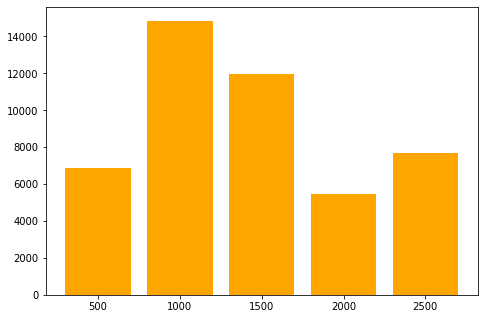

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lim = ['500', '1000', '1500', '2000', '2500']
val = [counter_0to20,counter_21to40,counter_41to60,counter_61to80,x]
ax.bar(lim,val, color = 'orange')
plt.show()